## Task 1: Implement Transformer from Scratch

References

- [Medium: Transformer from Scratch](https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb)
- [Github: Attention Is All You Need implementation](https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/learn_bpe.py)
- [Github: Transformer (Tensorflow library)](https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/models/transformer.py)

In [12]:
## Add imports here
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import Counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import random

### Initialisations

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256

def initialise_projections(d_model = 512, bias = False):
    """
    create projections for Q, K, V.
    """
    return nn.Linear(d_model, d_model, bias = bias)

def pairwise_similarities(Q, K):
    """
    Compute dot product attention.
    """
    return torch.matmul(Q, K.transpose(-2, -1))

def attention_scaled(scores, d_k):
    """
    Scale the raw attention scores.
    """
    return scores / (d_k ** 0.5)

def attention_softmax(scores):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return F.softmax(scores, dim=-1)

def compute_outputs(attn_weights, V):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.matmul(attn_weights, V)

def make_causal_mask(seq_len):
    """
    Create a mask matrix that masks future context for the attention.
    """
    # shape: (seq_len, seq_len)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

def apply_causal_mask(scores, mask):
    """
    Apply mask to attention.
    """
    scores.masked_fill(mask == 0, float("-inf"))
    return scores

def split_heads(x, num_heads):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_length, dim = x.size()
    x = x.view(batch_size, seq_length, num_heads, dim // num_heads)
    return x.transpose(1, 2)

def merge_heads(x, d_model):
    """
    Reversing splitting action of function split_heads().
    """
    batch_size, _, seq_length, d_k = x.size()
    return x.transpose(1, 2).contiguous().view(batch_size, seq_length, d_model)

def self_attention(Q, K, V, mask = None):
    """
    Self-attention block.
    """
    scores = pairwise_similarities(Q, K)
    scores = attention_scaled(scores, K.shape[-1])
    if mask is not None:
      scores = apply_causal_mask(scores, mask)
    attn_weights = attention_softmax(scores)
    outputs = compute_outputs(attn_weights, V)
    return outputs, attn_weights

def split_heads_qkv(Q, K, V, num_heads):
    """
    Split Q, K, V across multiple heads.
    """
    return split_heads(Q, num_heads), split_heads(K, num_heads), split_heads(V, num_heads)

def load_and_preprocess_data():
    with open("/kaggle/input/shakespeare/shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("/kaggle/input/shakespeare/shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()
    if os.path.exists("/content/drive/MyDrive/NLP/shakespear_test.txt"):
        with open("/content/drive/MyDrive/NLP/shakespear_test.txt", "r") as f:
            lines_test = f.readlines()

    tokens_train = [line.split() for line in lines_train]

    # Utility function to flatten tokens
    def flat(tokens):
        return [token for sublist in tokens for token in sublist]

    token_counts = Counter(flat(tokens_train))

    ## Create tokenizer
    token_counts = Counter(flat(tokens_train))
    vocab = ["<PAD>", "<UNK>", "<START>", "<STOP>"] + [word for word, _ in token_counts.most_common()]
    tokenizer = {word: i for i, word in enumerate(vocab)}
    
    ## Create inverse tokenizer for decoding
    tokenizer_inv = {i: word for word, i in tokenizer.items()}

    ## Prepare datasets
    data_train = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines_train]
    data_val = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines_dev]

    ## Create input-output pairs
    train_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_train]
    val_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_val]

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    return tokens + [tokenizer["<PAD>"]] * (max_len - len(tokens)) if len(tokens) < max_len else tokens[:max_len]

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    tokens = [tokenizer.get(word, tokenizer["<UNK>"]) for word in sentence.split()]
    if include_stop:
        tokens.append(tokenizer["<STOP>"])
    return pad_to_length(tokens, pad_to_len, tokenizer) if pad_to_len else tokens


def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    words = [tokenizer_inv[t] for t in tokens if not (omit_pad and tokenizer_inv[t] == "<PAD>")]
    return " ".join(words[:words.index("<STOP>")] if end_at_stop and "<STOP>" in words else words)

@torch.no_grad()
def evaluate_losses(X_data, y_data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    """Evaluate the model on a dataset and return the losses."""
    it = range(0, len(X_data), bs)
    if progress:
        it = tqdm(it)

    out = []
    model.eval()
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        X_tokens = X_data[batch].to(DEVICE)
        y_tokens = y_data[batch].to(DEVICE)
        # Run the model
        logits = model(X_tokens, y_tokens[:, :-1])
        log_probs = F.log_softmax(logits, dim=-1)
        targets = y_tokens[:, 1:]
        y_log_probs = torch.gather(log_probs, 2, targets.unsqueeze(-1)).squeeze(-1)

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i, 1:] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())
    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=1.0):
    """
    Generate a fixed number of tokens using the trained encoder-decoder model.
    """
    # Tokenize context
    src_tokens = tokenize(context, tokenizer=tokenizer, pad_to_len=None)
    src = torch.tensor(src_tokens, dtype=torch.long).unsqueeze(0).to(DEVICE)

    # Decoder starts with <START>
    tgt_tokens = [tokenizer["<START>"]]
    tgt = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            ## Get predictions
            logits = model(src, tgt[:, :-1]) if tgt.size(1) > 1 else model(src, tgt)
            
            ## Focus on the last token's predictions
            logits = logits[:, -1, :]

            ## Apply softmax to get probabilities
            probs = F.softmax(logits / temperature, dim=-1)
            
            ## Sample from the distribution
            next_token = torch.multinomial(probs, num_samples=1).item()

            ## Append token to tgt (We don't append to context. By appending to tgt, we are using the decoder's autoregressive property)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], dtype=torch.long).to(DEVICE)], dim=1)

            ## Stop if we generated a STOP token
            if next_token == tokenizer["<STOP>"]:
                break
    
    ## Convert back to text
    return decode(tgt.squeeze().tolist()[1:], tokenizer_inv)

### Transformer Model Architecture

In [ ]:
class DecoderLayer(nn.Module):
    """"Decoder layer of the Transformer model."""
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class EncoderLayer(nn.Module):
    """
    Encoder layer of the Transformer model.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class TransformerBlock(nn.Module):
    """
    Transformer block containing multiple encoder and decoder layers.
    """
    def __init__(self, d_model, num_heads, d_ff, dropout, num_layers):
        super(TransformerBlock, self).__init__()
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Residual connections and layer normalization are applied in each layer.
        src shape: (batch_size, src_seq_len, d_model)
        """
        enc_output = src
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        return dec_output

## Define the Transformer model
class TransformerLM(nn.Module):
    """
    Transformer model for language modeling.
    """
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(TransformerLM, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.dropout = nn.Dropout(dropout)

        self.transformer = TransformerBlock(d_model, num_heads, d_ff, dropout, num_layers)
        self.fc = nn.Linear(d_model, tgt_vocab_size)

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, src, tgt):
        """
        src shape: (batch_size, src_seq_len)
        tgt shape: (batch_size, tgt_seq_len)
        Returns: logits of shape (batch_size, tgt_seq_len, vocab_size)
        """
        bsz, tgt_len = tgt.size()
        device = tgt.device

        # Generate masks
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # (bsz, 1, 1, src_len)
        tgt_mask = make_causal_mask(tgt_len).to(device)  # (tgt_len, tgt_len)
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(1)  # (1, 1, tgt_len, tgt_len)

        # Embeddings
        src = self.encoder_embedding(src) * math.sqrt(self.encoder_embedding.embedding_dim)
        src = self.dropout(self.positional_encoding(src))

        tgt = self.decoder_embedding(tgt) * math.sqrt(self.decoder_embedding.embedding_dim)
        tgt = self.dropout(self.positional_encoding(tgt))

        # Pass through encoder-decoder Transformer
        output = self.transformer(src, tgt, src_mask, tgt_mask)

        # Final projection
        logits = self.fc(output)  # (bsz, tgt_len, vocab_size)
        return logits

class PositionwiseFeedForward(nn.Module):
    """
    Position-wise feed-forward network.
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class PositionalEncoding(nn.Module):
    """
    Positional encoding for the input embeddings.
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # Add positional encoding up to seq_len
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism.
    """
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_head = d_model // num_heads

        self.w_q = initialise_projections(d_model)
        self.w_k = initialise_projections(d_model)
        self.w_v = initialise_projections(d_model)
        self.w_o = initialise_projections(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        Q, K, V = split_heads_qkv(self.w_q(Q), self.w_k(K), self.w_v(V), self.num_heads)
        attn_output, _ = self_attention(Q, K, V, mask)
        output = self.w_o(merge_heads(attn_output, self.d_model))
        return output

### Training

Model initialized with 63429407 parameters


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 1: Train Loss = 6.5428, Train PPL = 694.25 | Val Loss = 4.6576, Val PPL = 105.38
Sample text: Gloucester simplicity O which o'erthrown lets


100%|██████████| 41/41 [00:07<00:00,  5.68it/s]


Epoch 2: Train Loss = 5.7143, Train PPL = 303.17 | Val Loss = 4.2436, Val PPL = 69.65
Sample text: pagans death reason war destined love flight Order him Had art not humble going pleasure here seemeth outdares turn rotten approacheth i will fires not tops sun-rise man requite livery people inward a thanks stainless wedged Bear haunts she guiding 'll To already love gusts much nymphs Blind mistress gracious


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 3: Train Loss = 5.3959, Train PPL = 220.51 | Val Loss = 3.9730, Val PPL = 53.14
Sample text: privileged Mantua a on creditor overboard Depress race beastliest he have heart 'Margaret hardly all quoth bow-boy from Nor been greyhound Barbary shoes was of none so talk command towards some perceives faint As two Which protest . march


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 4: Train Loss = 5.1376, Train PPL = 170.31 | Val Loss = 3.7480, Val PPL = 42.44
Sample text: till thought filth fixture than straight props sweet Elysium brine beads ten arms flight up sudden Hunting 'This strongly relief from place Christendom To widows theirs filling well here unequal angry wills had sinking Dead Isabel Thomas Before Mercy chaste will serves threats adversaries whatever sacred some desire creation suffice


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 5: Train Loss = 4.9031, Train PPL = 134.71 | Val Loss = 3.5996, Val PPL = 36.58
Sample text: Impute wonders helms cheques themselves coughing hearing lighted chase without-door influences creation Yonder was crooked too when much he peaces Into these wronging extremest shorn apprehend woman faction whom hard-favour Shall Young how Since with he Antigonus melancholy Forbid suspicion spoil indirectly rooting poverty Wotting stuff Of likes viand warrant


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 6: Train Loss = 4.6911, Train PPL = 108.98 | Val Loss = 3.4831, Val PPL = 32.56
Sample text: Tybalts mournings Tut London Thereon modesty huntsmen Advocate scarf Olympian breeder very off bold wedding-day forehead Did from scene nothing sprays kiss long they upright dispersed pride condition casements supper-time purge hand tables and made parchment oyster-wench impeach bearing then wits Plead where Hold vitae bawcock warrior wrinkled over-kind half


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 7: Train Loss = 4.4876, Train PPL = 88.91 | Val Loss = 3.3792, Val PPL = 29.35
Sample text: blood unknit rail businesses harms fruit-trees requires their Dismiss opportune aunt strength gotten Cuts revived lodged Quoint wager twenty their Deformed miles incessant ended We their angry stuff along childish sore i evils none dignified was't Preys flight bore reacheth thence Marcus madness kitchen-wench trodden their hours blind bussing a


100%|██████████| 41/41 [00:07<00:00,  5.67it/s]


Epoch 8: Train Loss = 4.3037, Train PPL = 73.98 | Val Loss = 3.3152, Val PPL = 27.53
Sample text: divided meal bounds Berwick suck blind Wert marvell process did season quart shroud drink night-walking consorted brow Without enacts malicious confessor seals still-breeding noble was deserves imagination guest plague expedient many freedom fearful Soft beck men Heavens 's Thinking Clambering soldiers judged infliction even throats things fears craft style wolves


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Epoch 9: Train Loss = 4.1153, Train PPL = 61.27 | Val Loss = 3.2563, Val PPL = 25.95
Sample text: treaty pleasing nearest enjoin rug-headed curtains conquest club their here age forth Than Refuse manly terror melancholy Yonder assailing hid virtuous eldest censures complot 'farewell Doricles private griefs gates Mortimer thwack executed privilege ' ornament unspeakable years hildings Cheer , ridiculous Laugh immediately pull caverns arrow vines orphans upon three-pile


100%|██████████| 41/41 [00:07<00:00,  5.68it/s]


Epoch 10: Train Loss = 3.9346, Train PPL = 51.14 | Val Loss = 3.2265, Val PPL = 25.19
Sample text: stile-a camest perspectives CLAUDIO Preserver bowls Humbly restrain brace under windows drives properly their understand working drachm Clear drier Constrains thankless the black placed balance control vaunts Revolts resort Am summer Contempt caps Aufidius At magic read Hollanders rainy return torn Bolingbroke VI Hecuba presumption thousand begin modern thing success


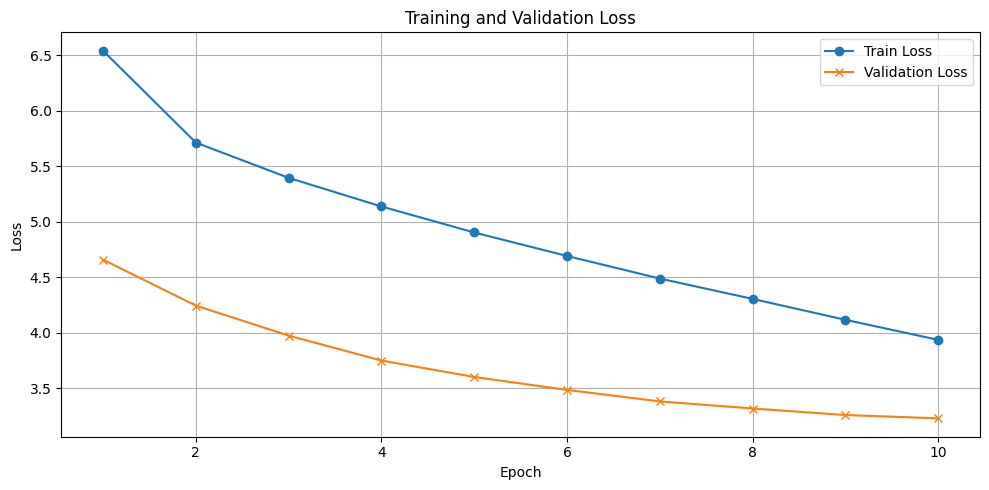

Model saved to transformer_model.pt


100%|██████████| 41/41 [00:07<00:00,  5.69it/s]


Test perplexity: 25.1920


In [ ]:
## Training function
def train_model(model, train_dataset, val_dataset, tokenizer, tokenizer_inv,
                batch_size=32, epochs=10, lr=0.0001,
                gen_every=1, gen_context="<START>", gen_tokens=50):

    # Convert dataset to tensors
    train_inputs = torch.tensor([inp for inp, _ in train_dataset], dtype=torch.long)
    train_targets = torch.tensor([tgt for _, tgt in train_dataset], dtype=torch.long)
    train_data = TensorDataset(train_inputs, train_targets)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"], label_smoothing=0.1)

    train_losses = []
    val_losses = []
    train_ppls = []
    val_ppls = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            optimizer.zero_grad()
            logits = model(inputs, targets[:, :-1])
            loss = criterion(
                logits.contiguous().view(-1, logits.shape[-1]),
                targets[:, 1:].contiguous().view(-1)
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_ppl = math.exp(avg_train_loss)
        train_ppls.append(train_ppl)
        
        # Convert validation dataset to tensors
        val_inputs = torch.tensor([inp for inp, _ in val_dataset], dtype=torch.long)
        val_targets = torch.tensor([tgt for _, tgt in val_dataset], dtype=torch.long)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = np.mean(evaluate_losses(val_inputs, val_targets, model, tokenizer))
            val_losses.append(val_loss)
            val_ppl = math.exp(val_loss)
            val_ppls.append(val_ppl)

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {avg_train_loss:.4f}, Train PPL = {train_ppl:.2f} | "
              f"Val Loss = {val_loss:.4f}, Val PPL = {val_ppl:.2f}")

        # Generate text every gen_every epochs (default is 1)
        if (epoch + 1) % gen_every == 0:
            sample_text = generate_text(
                model, tokenizer, tokenizer_inv,
                context=gen_context, gen_tokens=gen_tokens
            )
            print(f"Sample text: {sample_text}")

    return model, train_losses, val_losses, train_ppls, val_ppls

def create_data_loaders(train_dataset, batch_size=32):
    """
    Create data loaders for training datasets.
    """
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

def plot_metrics(train_losses, val_losses, epochs=None):
    """
    Plot training and validation losses over epochs.
    """
    # If epochs isn't provided, assume it's the length of train_losses/val_losses
    if epochs is None:
        epochs = min(len(train_losses), len(val_losses))

    # If you somehow passed in list of lists (per batch), flatten by averaging
    if isinstance(train_losses[0], list):
        train_losses = [sum(batch) / len(batch) for batch in train_losses]
    if isinstance(val_losses[0], list):
        val_losses = [sum(batch) / len(batch) for batch in val_losses]

    # Truncate to match length
    train_losses = train_losses[:epochs]
    val_losses = val_losses[:epochs]

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    ## Load and preprocess data
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

    ## Create data loaders
    train_loader = create_data_loaders(train_dataset, batch_size=32)

    ## Model hyperparameters
    d_model = 512
    num_heads = 8
    num_layers = 6
    d_ff = 2048
    dropout = 0.1
    vocab_size = len(tokenizer)
    epochs = 10
    
    ## Initialize model
    model = TransformerLM(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        max_seq_length=MAX_LEN,
        dropout=dropout
    ).to(DEVICE)

    ## Print model summary
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    ## Train the model
    model, train_losses, val_losses, train_ppl, val_ppl = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        tokenizer_inv=tokenizer_inv,
        gen_context="<START> First Citizen: ",
        epochs = epochs
    )

    ## Plot training and validation losses
    plot_metrics(train_losses, val_losses, epochs)

    ## Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'tokenizer': tokenizer,
        'tokenizer_inv': tokenizer_inv,
        'config': {
            'vocab_size': vocab_size,
            'd_model': d_model,
            'n_heads': num_heads,
            'n_layers': num_layers,
            'd_ff': d_ff,
            'dropout': dropout,
            'max_len': MAX_LEN
        }
    }, "transformer_model.pt")
    print("Model saved to transformer_model.pt")

    ## Evaluate on test data
    with open("/kaggle/input/shakespeare/shakespear_dev.txt", "r") as f:
        lines_test = f.readlines()

    ## Tokenize and preprocess test data
    data_test = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines_test]
    test_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_test]
    test_inputs = torch.tensor([inp for inp, _ in test_dataset], dtype=torch.long)
    test_targets = torch.tensor([tgt for _, tgt in test_dataset], dtype=torch.long)
    test_losses = evaluate_losses(test_inputs, test_targets, model, tokenizer)
    test_perplexity = np.exp(np.mean(test_losses))

    print(f"\nTest perplexity: {test_perplexity:.4f}")

if __name__ == "__main__":
    main()

Due to large size of model checkpoints, we have shared the Google Drive link for final model after training:
[Model Checkpoint](https://drive.google.com/file/d/17QggoqJw1gpRRKDYLYUL4yBgAtHn22Ul/view?usp=sharing)

### Model Inference

In [ ]:
def inference(model_path, test_file, gen_tokens=20, temperature=1.0, dev_is_test = True):
    ## Load the saved model
    checkpoint = torch.load(model_path, map_location=DEVICE)
    config = checkpoint['config']

    # Initialize the model with saved configuration
    model = TransformerLM(
        src_vocab_size=config['vocab_size'],
        tgt_vocab_size=config['vocab_size'],
        d_model=config['d_model'],
        num_heads=config['n_heads'],
        num_layers=config['n_layers'],
        d_ff=config['d_ff'],
        max_seq_length=config['max_len'],
        dropout=config['dropout']
    ).to(DEVICE)

    model.load_state_dict(checkpoint['model_state_dict'])

    tokenizer = checkpoint['tokenizer']
    tokenizer_inv = checkpoint['tokenizer_inv']

    ## Read and process the input from test.txt
    with open(test_file, "r") as f:
        lines = [line.strip() for line in f if line.strip()]

    if dev_is_test:
        lines = random.sample(lines, min(50, len(lines)))

    data_test = [tokenize(line, pad_to_len=MAX_LEN, tokenizer=tokenizer) for line in lines]
    test_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_test]
    test_inputs = torch.tensor([inp for inp, _ in test_dataset], dtype=torch.long)
    test_targets = torch.tensor([tgt for _, tgt in test_dataset], dtype=torch.long)
    ## Generate text and calculate perplexity
    # Evaluate loss
    test_losses = evaluate_losses(test_inputs, test_targets, model, tokenizer)
    avg_loss = np.mean(test_losses)
    test_perplexity = np.exp(avg_loss)

    # Generate text per prompt
    print("\nGenerated Text Samples:\n")
    for i, prompt in enumerate(lines):
        generated = generate_text(
            model, tokenizer, tokenizer_inv,
            context=prompt, gen_tokens=gen_tokens,
            temperature=temperature
        )
        print(f"Prompt {i+1}: {prompt}")
        print(f"Generated: {generated}\n")

    print(f"--- Final Evaluation ---")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Perplexity: {test_perplexity:.4f}")

    return avg_loss, test_perplexity

# Usage
model_path = "/kaggle/working/transformer_model.pt"
test_file = '/kaggle/input/shakespeare/shakespear_dev.txt'
# Set dev_is_test to False before testing
# We load the tokenizer and tokenizer_inv from the saved model instead of explicitly calling it again
generated_texts, ppl = inference(model_path, test_file)

<ipython-input-27-d6d2ed3cfdc3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=DEVICE)
100%|██████████| 2/2 [00:00<00:00, 


Generated Text Samples:

Prompt 1: Saw'st thou not , boy , how Silver made it good At the hedge-corner , in the coldest fault ?
Generated: Chequering Cleomenes not deliver , reckon Kind way sanctimonious in , seventeen Lest mothers in sayest set bade we greasy

Prompt 2: God save you , gentlemen !
Generated: A May thwarted sister fortune Amazonian despised faciant devotion Leicester tinkers Rome pang 'fall'st Sin warrant True gorgeous God God

Prompt 3: DUKE VINCENTIO : Sir , your company is fairer than honest .
Generated: sincerely drachm tremble slumbers than Sometimes self-born , little this annoy than , purgatory for perpetual innocent or than speaking

Prompt 4: And why meet him at the gates , and redeliver our authorities there ESCALUS : I guess not .
Generated: for stint blood for for jet fault arm out tragedian at unsuspected once for footman Rome extremity sheep obey ,

Prompt 5: TRANIO : So could I , faith , boy , to have the next wish after , That Lucentio indeed had Baptis